In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import joblib


In [2]:
def clean_column_names(df):
    """Clean column names to be compatible with XGBoost"""
    df = df.copy()
    # Remove brackets and clean special characters
    df.columns = (df.columns
                 .str.replace('[', '')
                 .str.replace(']', '')
                 .str.replace(' ', '_')
                 .str.replace('(', '')
                 .str.replace(')', '')
                 .str.replace('ö', 'oe')  # Handle German special characters
                 .str.replace('ä', 'ae')
                 .str.replace('ü', 'ue'))
    return df

def create_lagged_features(df, target_col, lag_hours=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24, 48, 72, 168, 336, 672, 1008, 2016, 8760]):
    """Create additional lagged features for time series data"""
    df_copy = df.copy()
    
    # Create lags for a variety of time periods (e.g., 1h, 2h, 1 day, 1 week, etc.)
    for lag in lag_hours:
        df_copy[f'{target_col}_lag_{lag}h'] = df_copy[target_col].shift(lag)
        
    # Drop rows with NaN values created by lagging
    df_copy = df_copy.dropna()
    
    return df_copy


def preprocess_load_data(data, split_date='2023-09-30'):
    """Preprocess the load data including lagged features"""
    # Create a copy of the data
    df = data.copy()
    
    # Store the original load column name
    original_load_col = 'Gesamt (Netzlast) [MWh] Berechnete Auflösungen'
    
    # Convert Date column to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    
    # Create lagged features before cleaning column names
    df = create_lagged_features(df, target_col=original_load_col)
    
    # Clean column names
    df = clean_column_names(df)
    
    # Get the cleaned load column name
    load_col = 'Gesamt_Netzlast_MWh_Berechnete_Aufloesungen'
    
    # Rename to 'load'
    df = df.rename(columns={load_col: 'load'})
    
    # Select features for the model (using cleaned names)
    base_features = [
        'hour', 'dayofyear_cos', 'dayofweek', 'dayofweek_sin',
        'is_workday', 'hour_cos', 'date_offset', 'dayofyear',
        'Kernenergie_MWh_Berechnete_Aufloesungen',
        'Steinkohle_MWh_Berechnete_Aufloesungen',
        'Holiday_Not_a_Holiday', 'hour_sin',
        'Wind_Onshore_MWh_Berechnete_Aufloesungen'
    ]
    
    # Add lagged feature names
    lag_features = [col for col in df.columns if 'lag' in col]
    feature_columns = base_features + lag_features
    
    # Split data based on date
    train_data = df[df['Date'] < split_date]
    test_data = df[df['Date'] >= split_date]
    
    # Split features and target
    X_train = train_data[feature_columns]
    y_train = train_data['load']
    X_test = test_data[feature_columns]
    y_test = test_data['load']
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to pandas DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)
    
    print(f"\nTraining data shape: {X_train_scaled.shape}")
    print(f"Testing data shape: {X_test_scaled.shape}")
    print(f"Training period: {train_data['Date'].min()} to {train_data['Date'].max()}")
    print(f"Testing period: {test_data['Date'].min()} to {test_data['Date'].max()}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_columns

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and evaluate multiple models"""
    models = {
        'XGBoost': xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.001,
            max_depth=30,
            random_state=42
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.001,
            max_depth=30,
            random_state=42
        ),
        'RandomForest': RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculate MAPE
        train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
        test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
        
        results[name] = {
            'train_mape': train_mape,
            'test_mape': test_mape,
            'model': model
        }
        
        print(f"{name} Results:")
        print(f"Train MAPE: {train_mape:.2f}%")
        print(f"Test MAPE: {test_mape:.2f}%")
    
    return results

In [3]:
# Example usage:
# Load the data
df = pd.read_csv('../Data/selected_features.csv')

# Preprocess the data
X_train, X_test, y_train, y_test, feature_names = preprocess_load_data(df)

# Train and evaluate models
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)


Training data shape: (34319, 34)
Testing data shape: (9541, 34)
Training period: 2019-10-31 18:00:00 to 2023-09-29 23:00:00
Testing period: 2023-09-30 00:00:00 to 2024-10-30 23:00:00

Training XGBoost...
XGBoost Results:
Train MAPE: 5.84%
Test MAPE: 6.37%

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6965
[LightGBM] [Info] Number of data points in the train set: 34319, number of used features: 34
[LightGBM] [Info] Start training from score 55789.419403
LightGBM Results:
Train MAPE: 6.05%
Test MAPE: 6.50%

Training RandomForest...
RandomForest Results:
Train MAPE: 0.78%
Test MAPE: 1.09%


In [6]:
# Save models
joblib.dump(results['XGBoost']['model'], 'xgboost_model.pkl')
joblib.dump(results['LightGBM']['model'], 'lightgbm_model.pkl')
joblib.dump(results['RandomForest']['model'], 'randomforest_model.pkl')

# # To load the models later:
# xgboost_model = joblib.load('xgboost_model.pkl')
# lightgbm_model = joblib.load('lightgbm_model.pkl')
# randomforest_model = joblib.load('randomforest_model.pkl')


['randomforest_model.pkl']

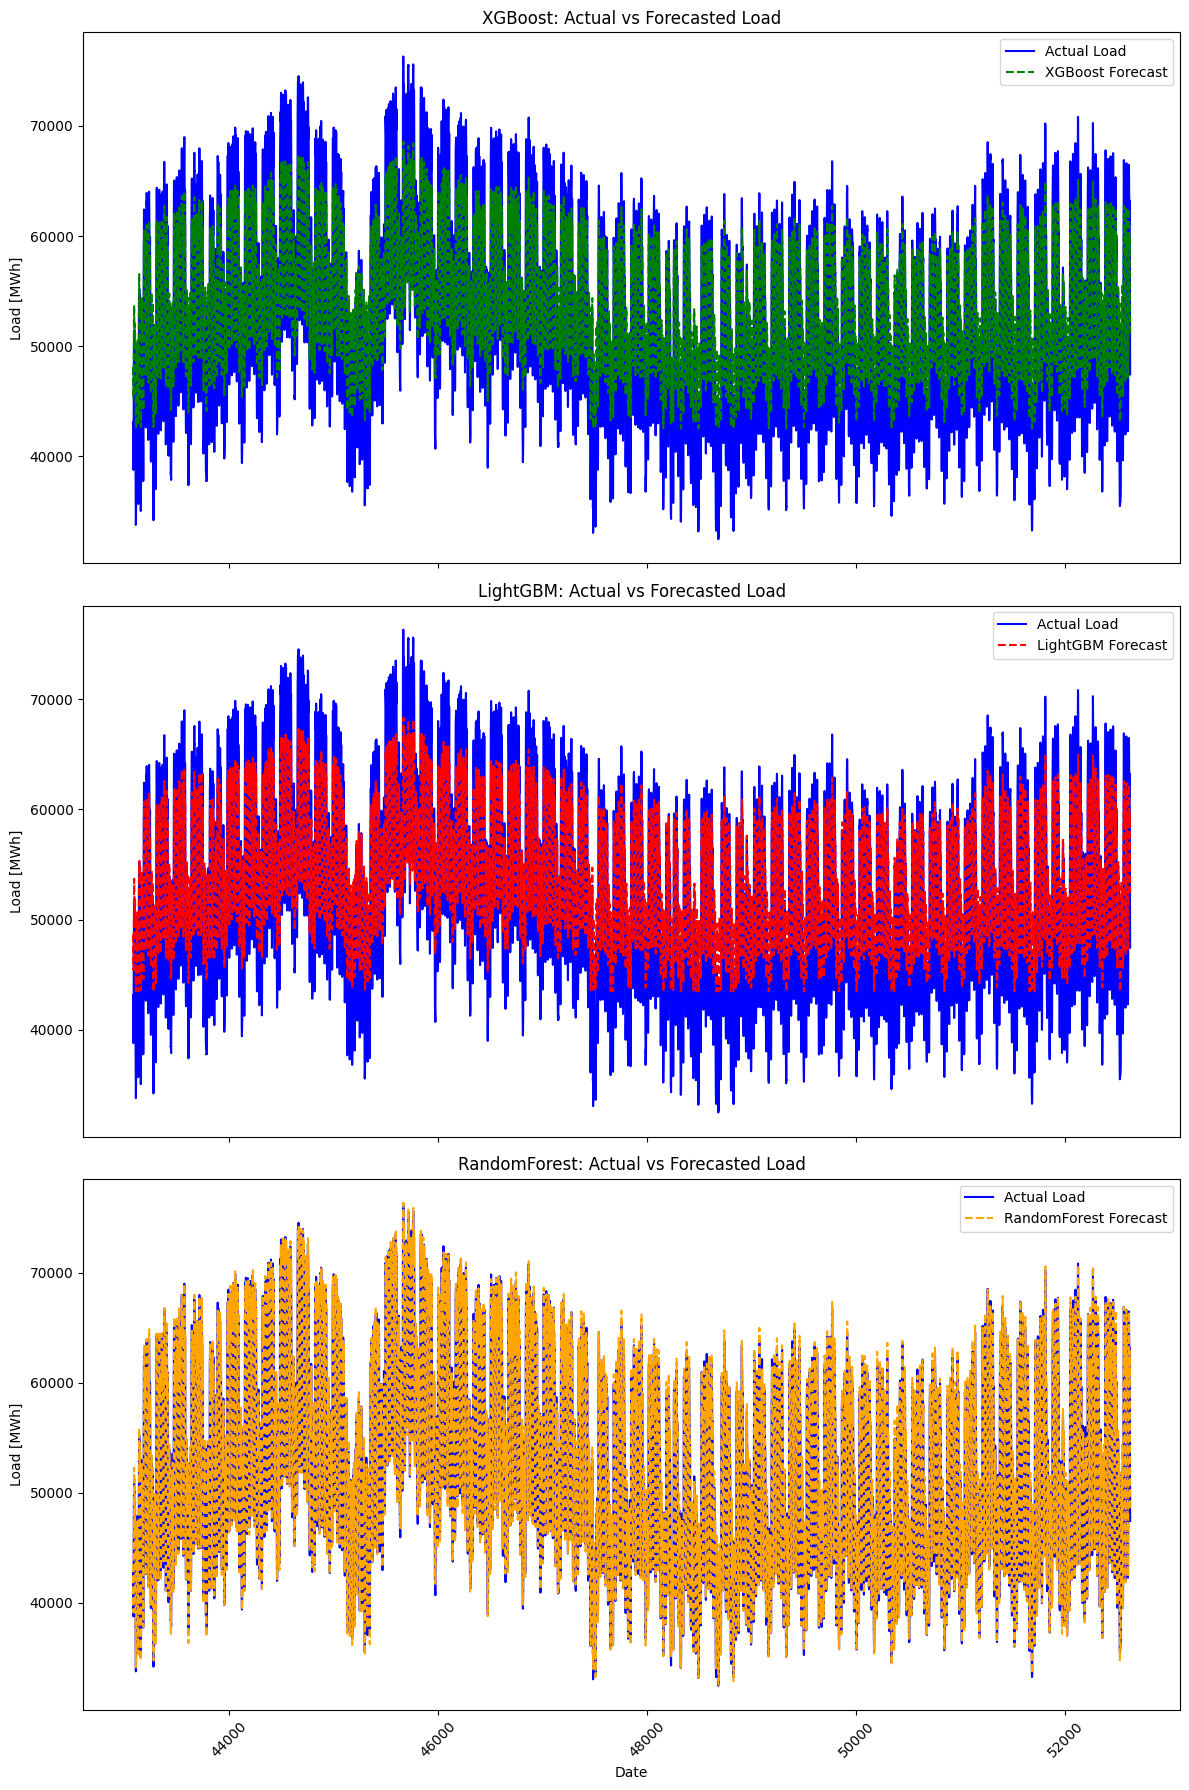

In [7]:

# Make predictions on the test set
xgboost_pred = results['XGBoost']['model'].predict(X_test)
lightgbm_pred = results['LightGBM']['model'].predict(X_test)
randomforest_pred = results['RandomForest']['model'].predict(X_test)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# XGBoost plot
axes[0].plot(y_test.index, y_test, label='Actual Load', color='blue')
axes[0].plot(y_test.index, xgboost_pred, label='XGBoost Forecast', color='green', linestyle='--')
axes[0].set_title('XGBoost: Actual vs Forecasted Load')
axes[0].set_ylabel('Load [MWh]')
axes[0].legend()

# LightGBM plot
axes[1].plot(y_test.index, y_test, label='Actual Load', color='blue')
axes[1].plot(y_test.index, lightgbm_pred, label='LightGBM Forecast', color='red', linestyle='--')
axes[1].set_title('LightGBM: Actual vs Forecasted Load')
axes[1].set_ylabel('Load [MWh]')
axes[1].legend()

# RandomForest plot
axes[2].plot(y_test.index, y_test, label='Actual Load', color='blue')
axes[2].plot(y_test.index, randomforest_pred, label='RandomForest Forecast', color='orange', linestyle='--')
axes[2].set_title('RandomForest: Actual vs Forecasted Load')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Load [MWh]')
axes[2].legend()

# Display the plots
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
